In [138]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as f

from IPython.display import clear_output
from time import time

SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [2]:
def preprocess(df):
    columns_to_drop = ['Record ID', 'Agency Code', 'Agency Name', 'Agency Type', 'City', 
                   'Incident', 'Victim Ethnicity', 'Victim Age', 'Perpetrator Age', 'Perpetrator Ethnicity', 'Record Source']

    df.drop(columns=columns_to_drop, inplace=True)
    df['Date'] = df['Year'].astype(str) + ' ' + df['Month']
    df.drop(columns=['Year', 'Month'], inplace=True)
    df['Date'] = df['Date'].apply(lambda item: datetime.strptime(item, '%Y %B'))
    
    cols = set(df.columns)
    non_enc_cols = set(('Perpetrator Count', 'Victim Count', 'Date'))
    enc_cols = set(df.columns) - non_enc_cols

    encoder = OneHotEncoder(sparse=False)
    
    cols = set(df.columns)
    non_enc_cols = set(('Perpetrator Count', 'Victim Count', 'Date'))
    enc_cols = set(df.columns) - non_enc_cols

    encoder = OneHotEncoder(sparse=False)

    enc_arr = encoder.fit_transform(df[list(enc_cols)].values).astype(np.int32)
    data_arr = np.concatenate((enc_arr, df[list(non_enc_cols)].values), axis=1)

    enc_df = pd.DataFrame(data=data_arr, 
                          columns=list(encoder.get_feature_names(list(enc_cols))) + list(non_enc_cols))
    
    res = enc_df.groupby('Date').sum()
    res['Incidents Count'] = res['Crime Solved_No'] + res['Crime Solved_Yes']
    return res

In [8]:
# print(tuple(df.columns))

('Record ID', 'Agency Code', 'Agency Name', 'Agency Type', 'City', 'State', 'Year', 'Month', 'Incident', 'Crime Type', 'Crime Solved', 'Victim Sex', 'Victim Age', 'Victim Race', 'Victim Ethnicity', 'Perpetrator Sex', 'Perpetrator Age', 'Perpetrator Race', 'Perpetrator Ethnicity', 'Relationship', 'Weapon', 'Victim Count', 'Perpetrator Count', 'Record Source')


In [3]:
df = pd.read_csv('database.csv')

data = preprocess(df)

C:\Users\dmitr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Text(0.5, 1.0, 'Log Time series')

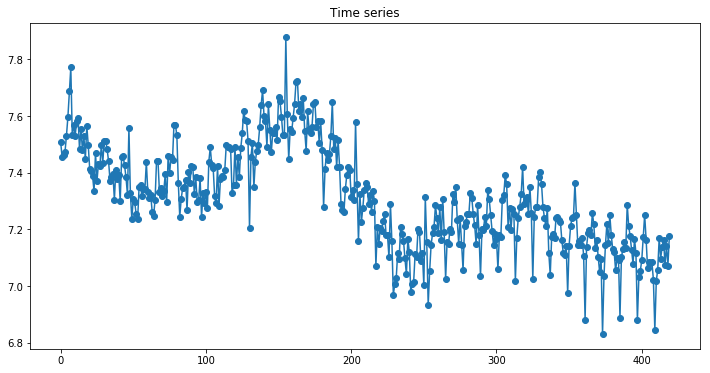

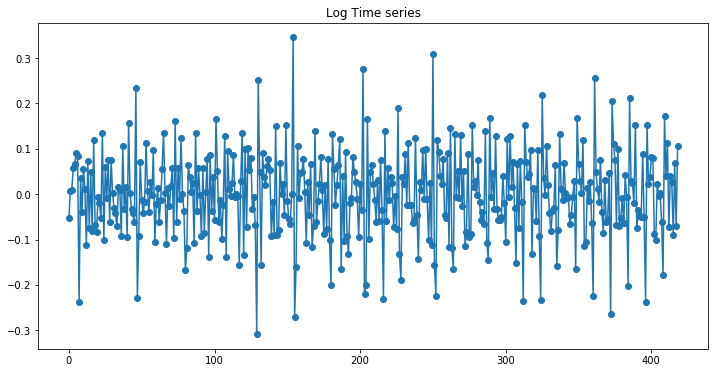

In [134]:
series = data.values[:, -1:]
diff_series = np.diff(series.reshape(-1)).reshape(-1, 1)

plt.figure(figsize=(12, 6))
plt.plot(np.log(series.reshape(-1)), 'o-')
plt.title('Time series')
plt.figure(figsize=(12, 6))
plt.plot(np.diff(np.log(series.reshape(-1))), 'o-')
plt.title('Log Time series')

In [6]:
def create_dataset(data, window, pred_horizon, offset=1):
    X = []
    y = []
    for i in range(0, data.shape[0]-pred_horizon-window, offset):
        sample_x = data[i:i+window]
        sample_y = data[i+window:i+window+pred_horizon, -1]
        X.append(sample_x)
        y.append(sample_y)
    X = np.array(X)
    y = np.array(y)
    return X, y

In [25]:
class LSTM_Series(nn.Module):
    def __init__(self, input_size, hidden_size, pred_horizon):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lin = nn.Linear(hidden_size, pred_horizon)
        
    def forward(self, x):
        out, (hidden, cell) = self.lstm(x)
        return self.lin(hidden.squeeze())

    
class RNN_Series(nn.Module):
    def __init__(self, input_size, hidden_size, pred_horizon):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.lin = nn.Linear(hidden_size, pred_horizon)
        
    def forward(self, x):
        out, hidden = self.rnn(x)
        return self.lin(hidden.squeeze())
    
    
class Dense_Series(nn.Module):
    def __init__(self, window, hidden_size, pred_horizon):
        super().__init__()
        self.lin1 = nn.Linear(window, hidden_size)
        self.lin2 = nn.Linear(hidden_size, pred_horizon)
        
    def forward(self, x):
        res = f.elu(self.lin1(x.squeeze()), alpha=0.1)
        return self.lin2(res)

In [12]:
from sklearn.model_selection import train_test_split

In [102]:
def train(model, X_train, X_test, y_train, y_test, criterion, optimizer, lr_scheduler, num_epochs):
    train_loss_history = []
    test_loss_history = []
    plt.figure(figsize=(14, 4))
    ax1 = plt.subplot(1, 2, 1)
    elapsed_time = 0
    for i in range(1, num_epochs+1):
        epoch_time = time()
        model.train()
        lr_scheduler.step()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        epoch_time = time() - epoch_time
        elapsed_time += epoch_time
        
        train_loss_history.append(np.sqrt(loss.item()))
        test_loss_history.append(np.sqrt(test(model, X_test, y_test, criterion)))
        
    ax1.plot(train_loss_history, label='Train')
    ax1.plot(test_loss_history, label='Test')
    ax1.grid()
    ax1.legend()
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss history')
    
    model.eval()
    y_pred = model(X_test)
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(y_pred[:, 0].detach().cpu().numpy(), 'o-', label='predict')
    ax2.plot(y_test[:, 0].detach().cpu().numpy(), 'o-', label='test')
    ax2.grid()
    ax2.legend()

    plt.show()
    print(f'Elapsed train time of {num_epochs} epochs: {elapsed_time:.3f}')
    print(f'Train RMSE: {train_loss_history[-1]}')
    print(f'Test RMSE: {test_loss_history[-1]}')
    return train_loss_history, test_loss_history

            
def test(model, X, y, criterion):
    model.eval()
    with torch.no_grad():
        y_pred = model(X)
        loss = criterion(y_pred, y)
        return loss.item()

In [103]:
# time_series = np.diff(np.log(data.values[:, -1:].reshape(-1))).reshape(-1, 1)
# time_series = np.diff(data.values[:, -1:].reshape(-1)).reshape(-1, 1)
# time_series = np.log(series)

time_series = data.values[:, -1:]

## Полносвязная сеть ##

**Обычный (неизмененный) временной ряд**

In [104]:
device = torch.device('cuda:0')

window = 24
pred_horizon = 6

X, y = create_dataset(time_series, window=window, pred_horizon=pred_horizon)

Hidden dimension: 16


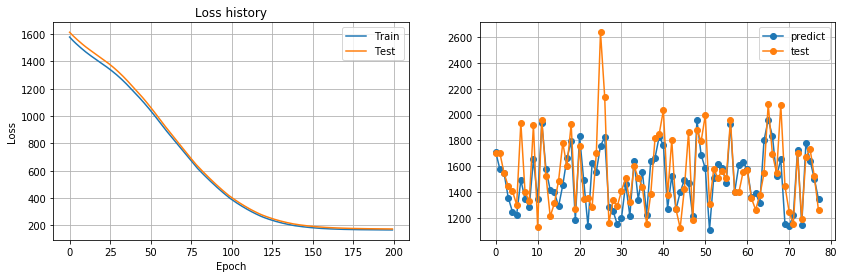

Elapsed train time of 200 epochs: 0.468
Train RMSE: 167.03939117203763
Test RMSE: 174.0910434406377
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hidden dimension: 64


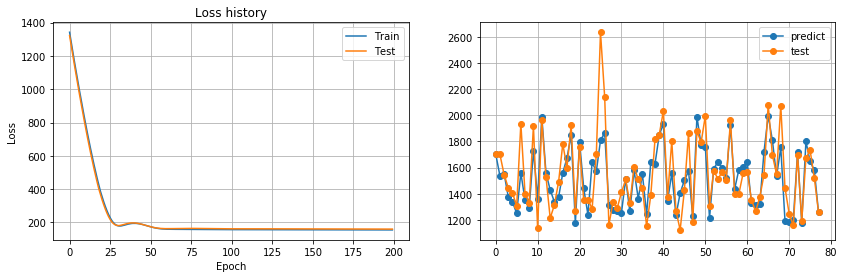

Elapsed train time of 200 epochs: 0.441
Train RMSE: 155.44306006340392
Test RMSE: 160.32062601237558
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hidden dimension: 256


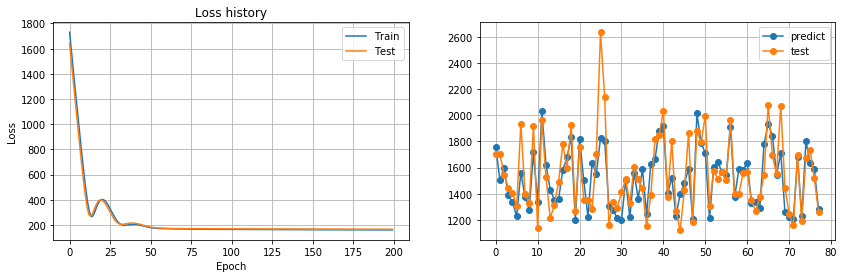

Elapsed train time of 200 epochs: 0.424
Train RMSE: 160.89267579663158
Test RMSE: 166.1681541955317
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hidden dimension: 1024


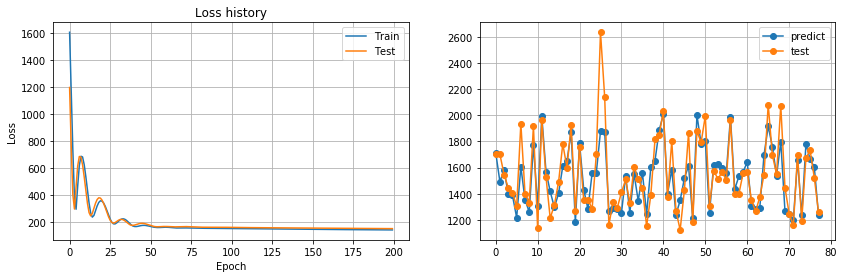

Elapsed train time of 200 epochs: 0.424
Train RMSE: 140.59084307397123
Test RMSE: 150.1852827031497
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [105]:
hid_dims = (16, 64, 256, 1024)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.FloatTensor(y_test).to(device)

for hid_dim in hid_dims:
    model = Dense_Series(window, hid_dim, pred_horizon).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)
    num_epochs = 200
    print(f'Hidden dimension: {hid_dim}')
    res = train(model, X_train, X_test, y_train, y_test, criterion, optimizer, lr_scheduler, num_epochs=num_epochs)
    print('---'*80)

In [106]:
device = torch.device('cuda:0')

window = 12
pred_horizon = 1

X, y = create_dataset(time_series, window=window, pred_horizon=pred_horizon)

Hidden dimension: 16


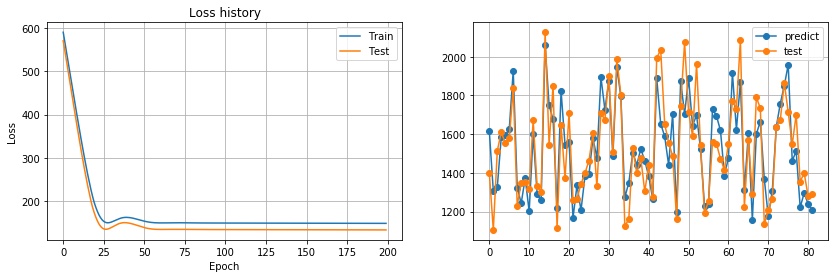

Elapsed train time of 200 epochs: 0.428
Train RMSE: 148.101257327124
Test RMSE: 132.93055047655523
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hidden dimension: 64


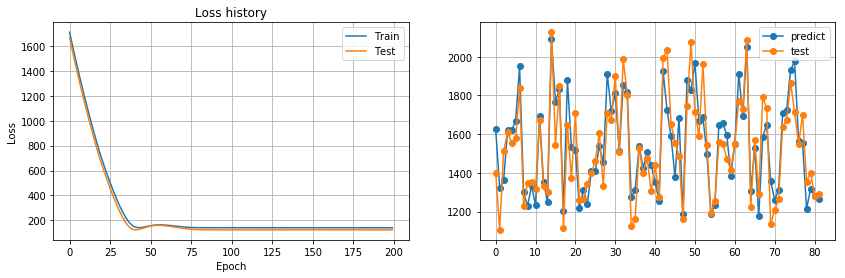

Elapsed train time of 200 epochs: 0.466
Train RMSE: 139.9193126859191
Test RMSE: 123.25984446612165
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hidden dimension: 256


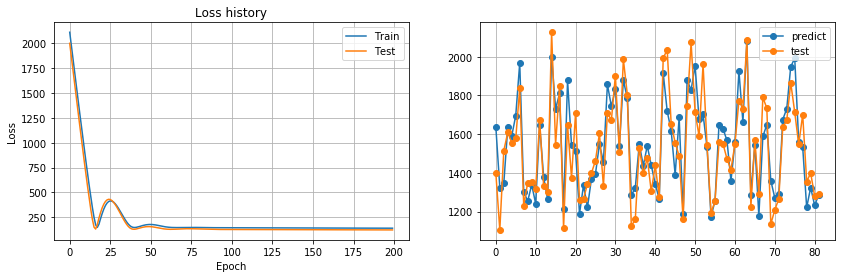

Elapsed train time of 200 epochs: 0.441
Train RMSE: 141.00011081555928
Test RMSE: 123.7271522468896
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hidden dimension: 1024


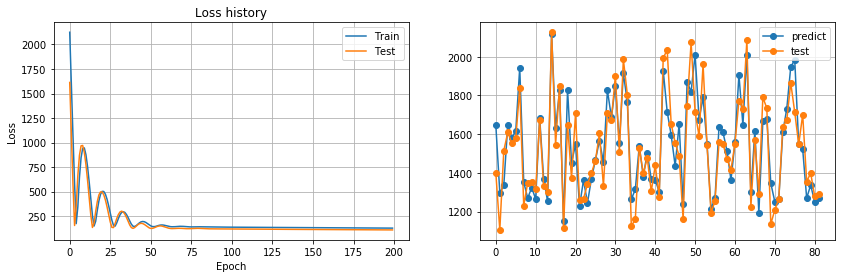

Elapsed train time of 200 epochs: 0.422
Train RMSE: 127.8902422489691
Test RMSE: 109.6615309358186
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [107]:
hid_dims = (16, 64, 256, 1024)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.FloatTensor(y_test).to(device)

for hid_dim in hid_dims:
    model = Dense_Series(window, hid_dim, pred_horizon).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)
    num_epochs = 200
    print(f'Hidden dimension: {hid_dim}')
    res = train(model, X_train, X_test, y_train, y_test, criterion, optimizer, lr_scheduler, num_epochs=num_epochs)
    print('---'*80)

**Прологарифимированный временной ряд**

In [108]:
device = torch.device('cuda:0')

window = 24
pred_horizon = 6

X, y = create_dataset(np.log(time_series), window=window, pred_horizon=pred_horizon)

Hidden dimension: 16


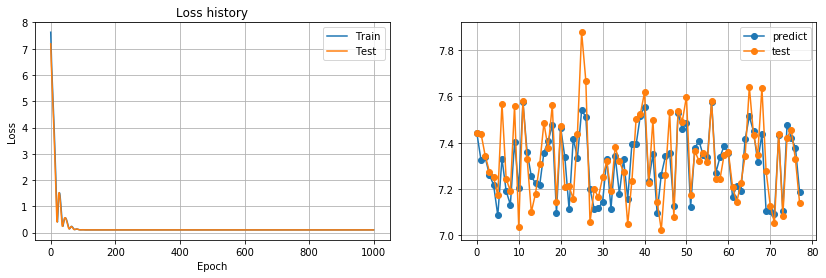

Elapsed train time of 1000 epochs: 2.204
Train RMSE: 0.10318262592578797
Test RMSE: 0.10260410062752291
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hidden dimension: 64


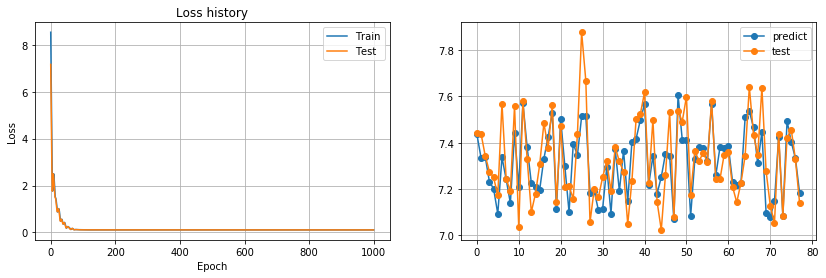

Elapsed train time of 1000 epochs: 2.138
Train RMSE: 0.10752435910700889
Test RMSE: 0.10722658873038327
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hidden dimension: 256


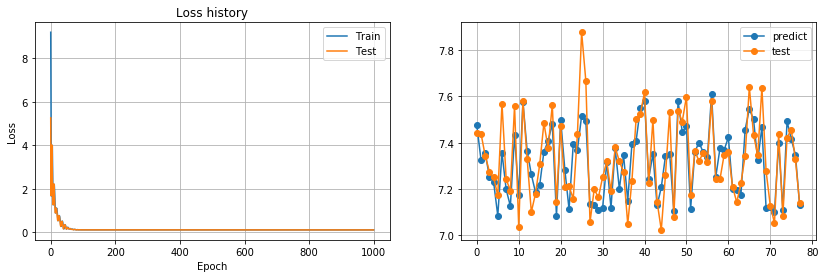

Elapsed train time of 1000 epochs: 2.136
Train RMSE: 0.10336554191714722
Test RMSE: 0.10207388584380045
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hidden dimension: 1024


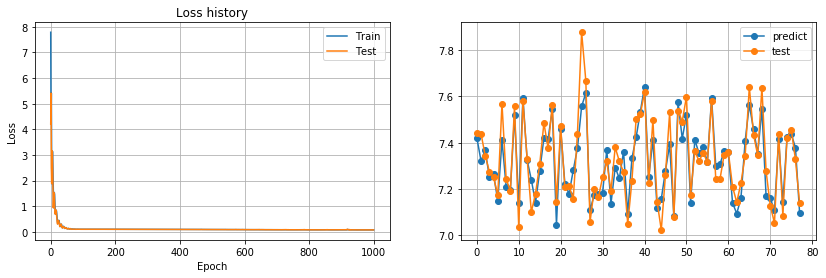

Elapsed train time of 1000 epochs: 2.247
Train RMSE: 0.07906100033762643
Test RMSE: 0.08026582247865907
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [109]:
hid_dims = (16, 64, 256, 1024)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.FloatTensor(y_test).to(device)

for hid_dim in hid_dims:
    model = Dense_Series(window, hid_dim, pred_horizon).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
    num_epochs = 1000
    print(f'Hidden dimension: {hid_dim}')
    res = train(model, X_train, X_test, y_train, y_test, criterion, optimizer, lr_scheduler, num_epochs=num_epochs)
    print('---'*80)

## RNN ##

**Обычный (неизмененный) временной ряд**

In [114]:
device = torch.device('cuda:0')

window = 24
pred_horizon = 6

X, y = create_dataset(time_series, window=window, pred_horizon=pred_horizon)

Hidden dimension: 16


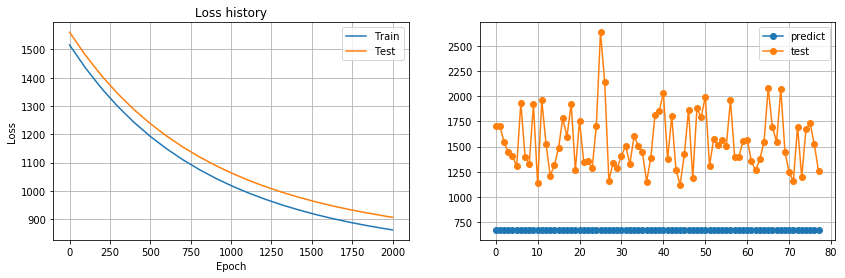

Elapsed train time of 2000 epochs: 8.228
Train RMSE: 862.1726552727127
Test RMSE: 906.8463555090244
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hidden dimension: 64


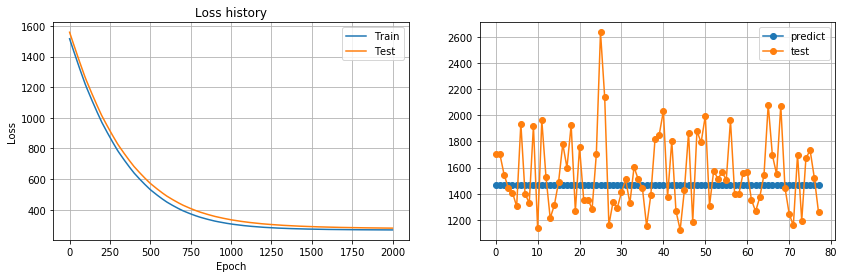

Elapsed train time of 2000 epochs: 8.799
Train RMSE: 268.1047486524623
Test RMSE: 279.6708584434567
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hidden dimension: 256


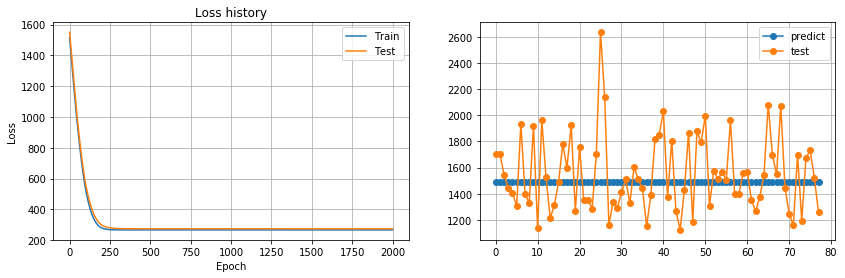

Elapsed train time of 2000 epochs: 9.161
Train RMSE: 266.7179719525852
Test RMSE: 273.81805660876347
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hidden dimension: 1024


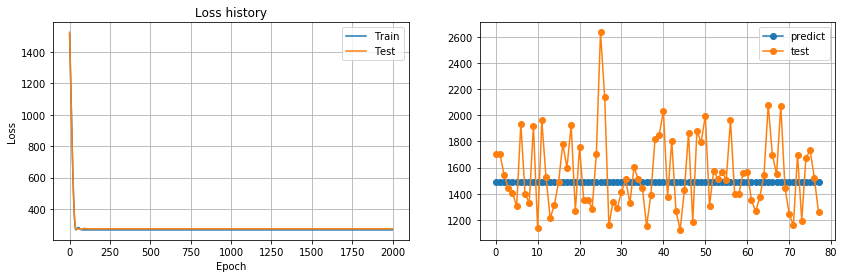

Elapsed train time of 2000 epochs: 16.357
Train RMSE: 266.7179719525852
Test RMSE: 273.81775702554427
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [117]:
hid_dims = (16, 64, 256, 1024)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.FloatTensor(y_test).to(device)

for hid_dim in hid_dims:
    model = RNN_Series(X.shape[2], hid_dim, pred_horizon).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
    num_epochs = 2000
    print(f'Hidden dimension: {hid_dim}')
    res = train(model, X_train, X_test, y_train, y_test, criterion, optimizer, lr_scheduler, num_epochs=num_epochs)
    print('---'*80)

**Прологарифмированный временной ряд**

In [124]:
device = torch.device('cuda:0')

window = 24
pred_horizon = 6

X, y = create_dataset(np.log(time_series), window=window, pred_horizon=pred_horizon)

Hidden dimension: 16


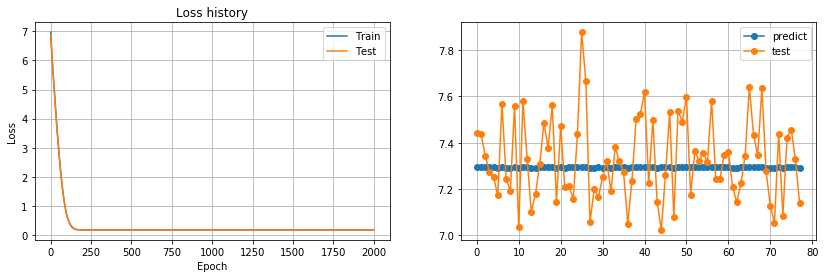

Elapsed train time of 2000 epochs: 8.192
Train RMSE: 0.17406674947465325
Test RMSE: 0.1748510704093258
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hidden dimension: 64


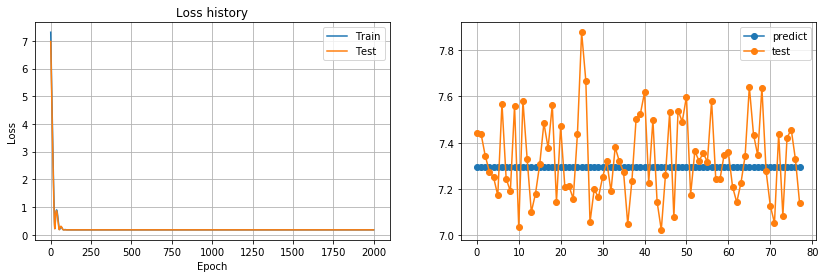

Elapsed train time of 2000 epochs: 8.604
Train RMSE: 0.17444327623452566
Test RMSE: 0.17522501890330974
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hidden dimension: 256


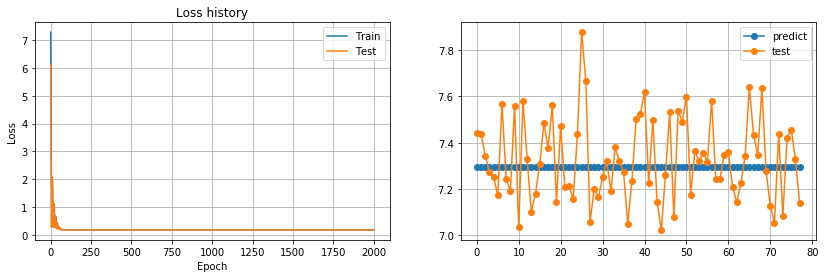

Elapsed train time of 2000 epochs: 8.892
Train RMSE: 0.1744521438017541
Test RMSE: 0.17523443153166146
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hidden dimension: 1024


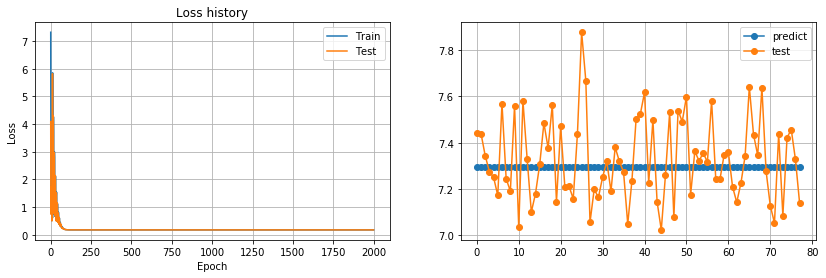

Elapsed train time of 2000 epochs: 16.818
Train RMSE: 0.17440778009734237
Test RMSE: 0.17519135040089745
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [125]:
hid_dims = (16, 64, 256, 1024)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.FloatTensor(y_test).to(device)

for hid_dim in hid_dims:
    model = RNN_Series(X.shape[2], hid_dim, pred_horizon).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
    num_epochs = 2000
    print(f'Hidden dimension: {hid_dim}')
    res = train(model, X_train, X_test, y_train, y_test, criterion, optimizer, lr_scheduler, num_epochs=num_epochs)
    print('---'*80)

**Многомерный (используем one-hot агрегированные фичи) временной ряд**

In [126]:
device = torch.device('cuda:0')

window = 24
pred_horizon = 6

X, y = create_dataset(data.values, window=window, pred_horizon=pred_horizon)

Hidden dimension: 16


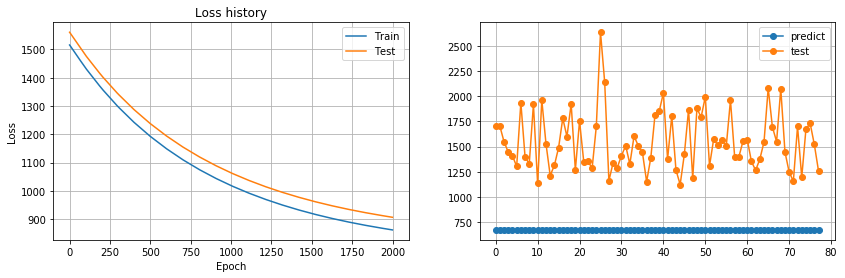

Elapsed train time of 2000 epochs: 9.577
Train RMSE: 862.0367596570346
Test RMSE: 906.7091940087516
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hidden dimension: 64


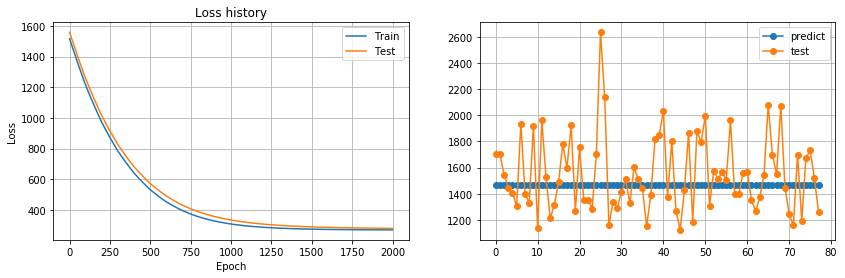

Elapsed train time of 2000 epochs: 8.850
Train RMSE: 269.5193638683499
Test RMSE: 279.51517736072935
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hidden dimension: 256


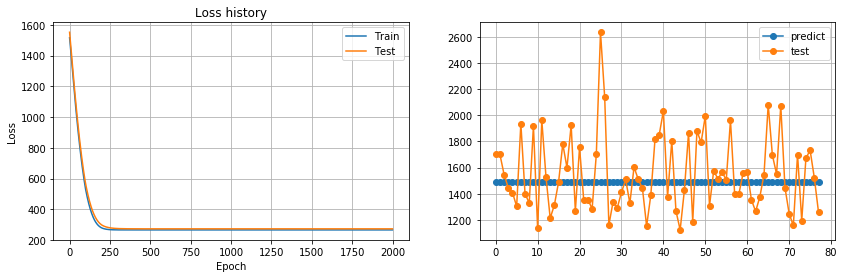

Elapsed train time of 2000 epochs: 9.406
Train RMSE: 266.8133418234553
Test RMSE: 273.8090547032731
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hidden dimension: 1024


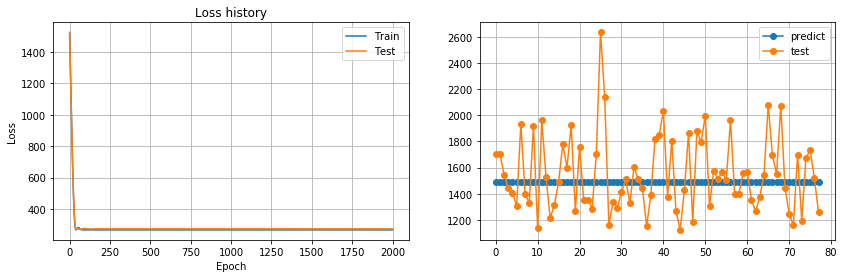

Elapsed train time of 2000 epochs: 17.329
Train RMSE: 266.758991179304
Test RMSE: 273.8141762674095
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [121]:
hid_dims = (16, 64, 256, 1024)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.FloatTensor(y_test).to(device)

for hid_dim in hid_dims:
    model = RNN_Series(X.shape[2], hid_dim, pred_horizon).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
    num_epochs = 2000
    print(f'Hidden dimension: {hid_dim}')
    res = train(model, X_train, X_test, y_train, y_test, criterion, optimizer, lr_scheduler, num_epochs=num_epochs)
    print('---'*80)

## LSTM ##

**Обычный временной ряд**

In [129]:
device = torch.device('cuda:0')

window = 24
pred_horizon = 6

X, y = create_dataset(time_series, window=window, pred_horizon=pred_horizon)

Hidden dimension: 16


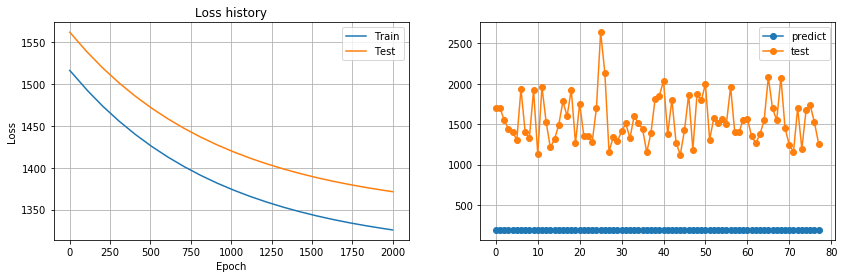

Elapsed train time of 2000 epochs: 8.608
Train RMSE: 1325.7256503515348
Test RMSE: 1371.3713938973644
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hidden dimension: 64


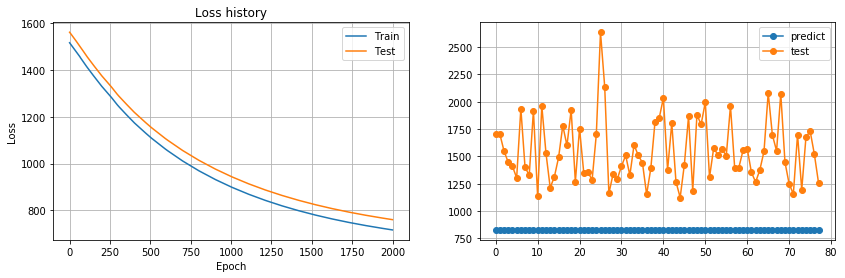

Elapsed train time of 2000 epochs: 9.068
Train RMSE: 716.8464139897751
Test RMSE: 760.7270781955905
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hidden dimension: 256


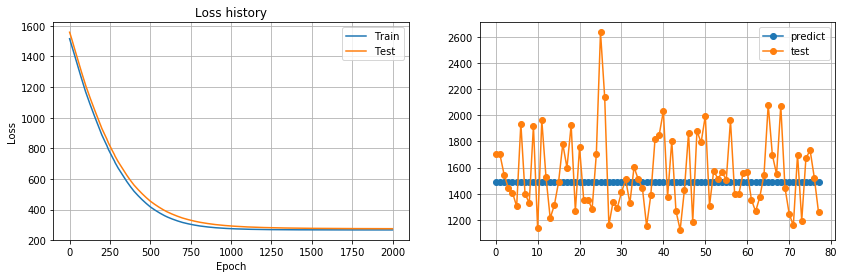

Elapsed train time of 2000 epochs: 11.511
Train RMSE: 266.7746884076523
Test RMSE: 274.79185304517307
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hidden dimension: 1024


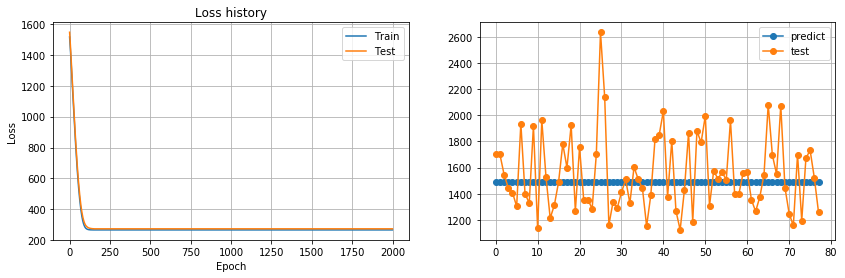

Elapsed train time of 2000 epochs: 40.649
Train RMSE: 266.7179719525852
Test RMSE: 273.8177142279148
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [130]:
hid_dims = (16, 64, 256, 1024)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.FloatTensor(y_test).to(device)

for hid_dim in hid_dims:
    model = LSTM_Series(X.shape[2], hid_dim, pred_horizon).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
    num_epochs = 2000
    print(f'Hidden dimension: {hid_dim}')
    res = train(model, X_train, X_test, y_train, y_test, criterion, optimizer, lr_scheduler, num_epochs=num_epochs)
    print('---'*80)

**Многомерный (используем one-hot агрегированные фичи) временной ряд**

In [131]:
device = torch.device('cuda:0')

window = 24
pred_horizon = 6

X, y = create_dataset(data.values, window=window, pred_horizon=pred_horizon)

Hidden dimension: 16


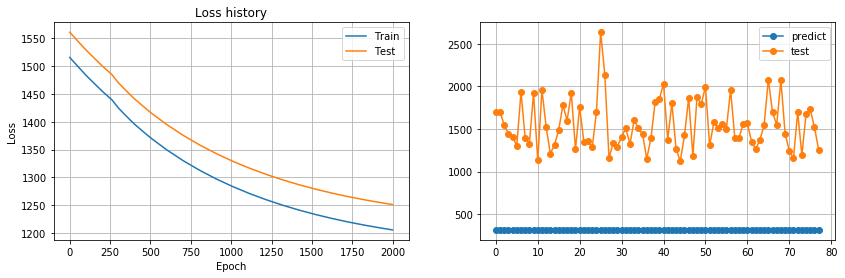

Elapsed train time of 2000 epochs: 9.404
Train RMSE: 1205.4528713309367
Test RMSE: 1251.0841298649743
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hidden dimension: 64


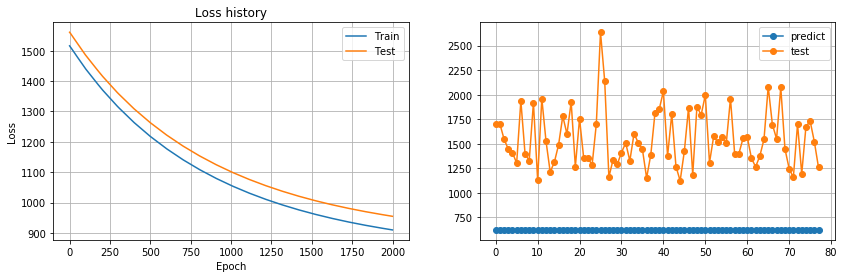

Elapsed train time of 2000 epochs: 9.874
Train RMSE: 909.83041002156
Test RMSE: 954.6817205226043
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hidden dimension: 256


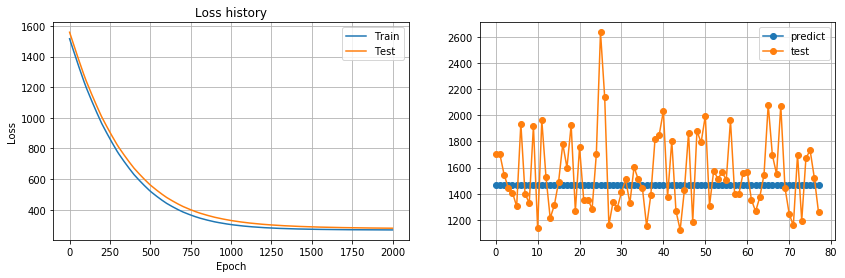

Elapsed train time of 2000 epochs: 12.132
Train RMSE: 267.8254153828572
Test RMSE: 278.92456697555343
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Hidden dimension: 1024


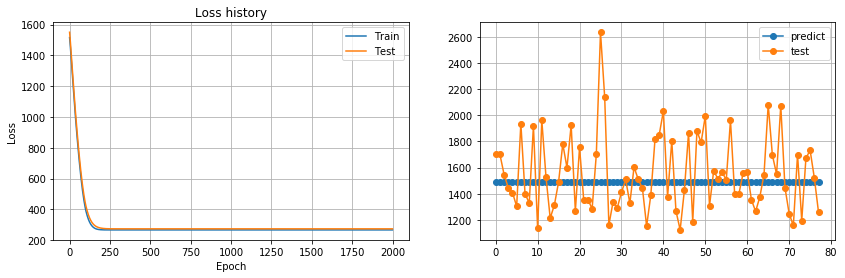

Elapsed train time of 2000 epochs: 43.974
Train RMSE: 266.80331297137224
Test RMSE: 273.8069718113474
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [132]:
hid_dims = (16, 64, 256, 1024)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.FloatTensor(y_test).to(device)

for hid_dim in hid_dims:
    model = LSTM_Series(X.shape[2], hid_dim, pred_horizon).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
    num_epochs = 2000
    print(f'Hidden dimension: {hid_dim}')
    res = train(model, X_train, X_test, y_train, y_test, criterion, optimizer, lr_scheduler, num_epochs=num_epochs)
    print('---'*80)